# An attempt to perform Image Super Resolution using AutoEncoders

It is well known that GANs are more suited towards applications such as Image Super Resolution, while AutoEncoders are not. 

A very well-written article comparing GANs and AutoEncoders is written by Matthew Stewart, and the same can be found here: [GANs vs. Autoencoders: Comparison of Deep Generative Models](https://towardsdatascience.com/gans-vs-autoencoders-comparison-of-deep-generative-models-985cf15936ea)

However, I was still curious to see the results myself as the question remains: What happens if we do attempt to train?

.... Please follow along to find out :)

In [1]:
# Imports
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm

### Datasets

I attempted to use two datasets:
- [Gender Clssification Dataset (Kaggle)](https://www.kaggle.com/cashutosh/gender-classification-dataset) - I combined male and female images together for this application
- [COCO 2017 Dataset](https://cocodataset.org) - I just used the images

In [2]:
train_dir = "/home/ani/Documents/pycodes/Dataset/train"
val_dir = "/home/ani/Documents/pycodes/Dataset/val"

train_images = glob(os.path.join(train_dir, "*"))
val_images = glob(os.path.join(val_dir, "*"))

Dims:  (480, 640, 3)


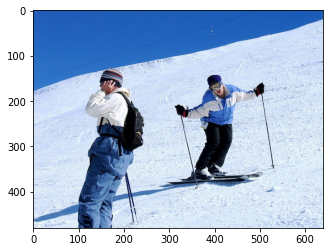

In [3]:
img_path = train_images[0]
img = cv2.imread(img_path)
print("Dims: ", img.shape)
plt.imshow(img[:,:,::-1])
plt.show()

0 255 179.2043546040853
Dims:  (512, 512, 3)


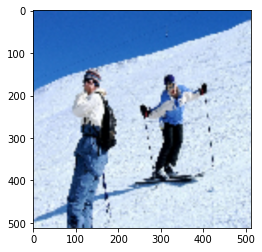

In [4]:
# Visualize the Downsampled and then Upsampled Image
img = tf.io.read_file(img_path)
img = tf.io.decode_jpeg(img)
img = tf.image.resize(img, [128, 128], preserve_aspect_ratio=False)
img = tf.image.resize(img, [512, 512], preserve_aspect_ratio=False)
img = tf.cast(img, dtype=tf.uint8)
print(np.min(img), np.max(img), np.mean(img))
print("Dims: ", img.shape)
plt.imshow(img)
plt.show()

In [5]:
# A quick Tensorflow Data loader
class DataLoader:
    def __init__(self, data_dir, downsample_shape=(128, 128), target_shape=(512, 512)):
        self.files = self.load_files(data_dir)
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.downsample_shape = downsample_shape
        self.target_shape = target_shape
    
    def load_files(self, root_dir):
        if not root_dir.endswith("*"):
            root_dir = os.path.join(root_dir, "*")
        
        return tf.data.Dataset.list_files(root_dir, shuffle=True)
    
    def process_image(self, image_path):
        img = tf.io.read_file(image_path)
        img = tf.io.decode_jpeg(img)
    
        input_image = tf.image.resize(
            img, 
            self.downsample_shape, 
        )
        input_image = tf.image.resize(
            input_image, 
            self.target_shape, 
        ) / 255
        
        target_image = tf.image.resize(
            img, 
            self.target_shape, 
        ) / 255.
        
        return input_image, target_image
    
    def data_generator(self, batch_size=64):
        dataset = self.files.map(self.process_image)
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size = self.AUTOTUNE)
        return dataset
    
test_dataset = DataLoader(train_dir)
batch = test_dataset.data_generator(10)
inputs, targets = next(iter(batch))
print(f"Input Shape: {inputs.shape}, Target Shape: {targets.shape}")

Input Shape: (10, 512, 512, 3), Target Shape: (10, 512, 512, 3)


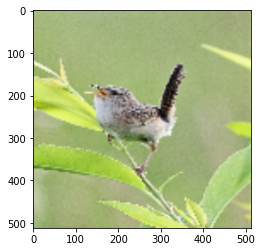

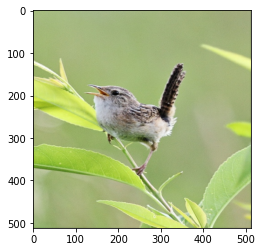

In [6]:
# Data Loader Testing & Verification
index = 1
plt.imshow(inputs[index])
plt.show()
plt.imshow(targets[index])
plt.show()

### Model Architecture & Training

In [7]:
# Callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    "weights.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=4,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=10e-8,
)

# Model Architecture

input_img = tf.keras.Input(shape=(None, None, 3))
    
# encoding architecture
x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x3 = tf.keras.layers.MaxPool2D(padding='same')(x2)
x4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x4)
x6 = tf.keras.layers.MaxPool2D(padding='same')(x5)
encoded = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x6)

# decoding architecture
x7 = tf.keras.layers.UpSampling2D()(encoded)
x8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x7)
x9 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x8)
x10 = tf.keras.layers.Add()([x5, x9])
x11 = tf.keras.layers.UpSampling2D()(x10)
x12 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x11)
x13 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x12)
x14 = tf.keras.layers.Add()([x2, x13])
decoded = tf.keras.layers.Conv2D(3, (3, 3), padding='same',activation='relu')(x14)
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.summary()

# Hyper Params
batch_size = 16
epochs = 200
lr = 0.001
downsample_shape=(80, 80)
target_shape=(224, 224)

opt = tf.keras.optimizers.Adam(learning_rate=lr)

autoencoder.compile(
    loss="binary_crossentropy", 
    optimizer=opt, 
    metrics=[
        "mse",
])

# Dataset Generator
train_dataset = DataLoader(train_dir, downsample_shape=downsample_shape, target_shape=target_shape)
train_generator = train_dataset.data_generator(batch_size)

val_dataset = DataLoader(val_dir, downsample_shape=downsample_shape, target_shape=target_shape)
val_generator = train_dataset.data_generator(batch_size)

# Calculate Num Steps
train_steps = len(list(train_dataset.files)) // batch_size + 1
val_steps = len(list(val_dataset.files)) // batch_size + 1


# Train
history = autoencoder.fit(
    train_generator,
    validation_data=val_generator,
    batch_size=batch_size, 
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    epochs=epochs, 
    callbacks=[
        early_stop_cb, 
        model_ckpt_cb, 
        reduce_lr_cb
    ])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

7393/7393 [==============================] - 1101s 149ms/step - loss: 0.5195 - mse: 0.0061 - val_loss: 0.5198 - val_mse: 0.0060
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


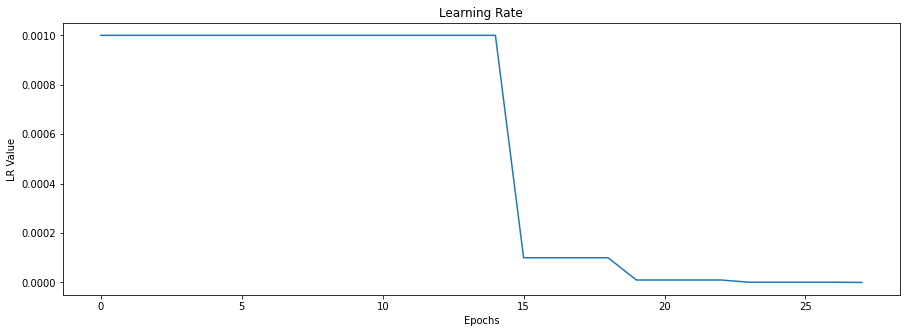

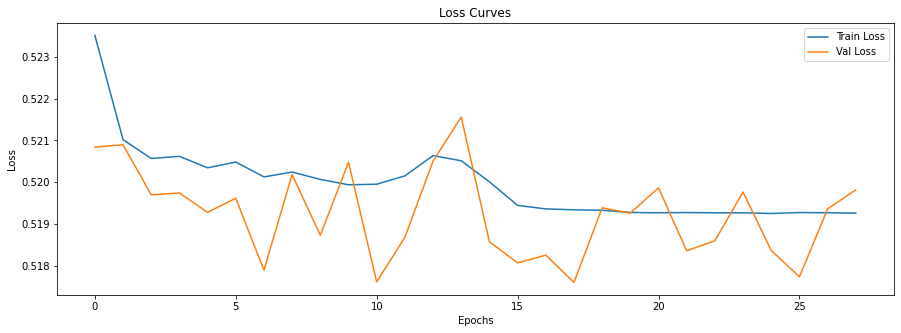

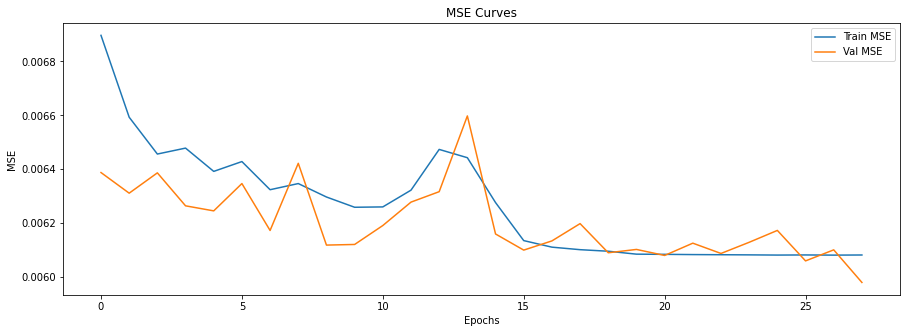

In [8]:
plt.rcParams["figure.figsize"] = (15, 5)
# Matplotlib Plots (For Easy Rendering)

# Learning Rate
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.xlabel("Epochs")
plt.ylabel("LR Value")
plt.show()

# Loss Curves
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title('Loss Curves')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# MSE Curves
plt.plot(history.history['mse'], label="Train MSE")
plt.plot(history.history['val_mse'], label="Val MSE")
plt.title('MSE Curves')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [10]:
%time
inputs, targets = next(iter(val_generator))
preds = autoencoder.predict(inputs)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


### Prediction Results Visualization

The Results are not bad, but they look as if someone has smoothened the image out with Averaging Filter.
The model is unable to reconstruct the finer details and edges. But it definitely looks better than the input image.

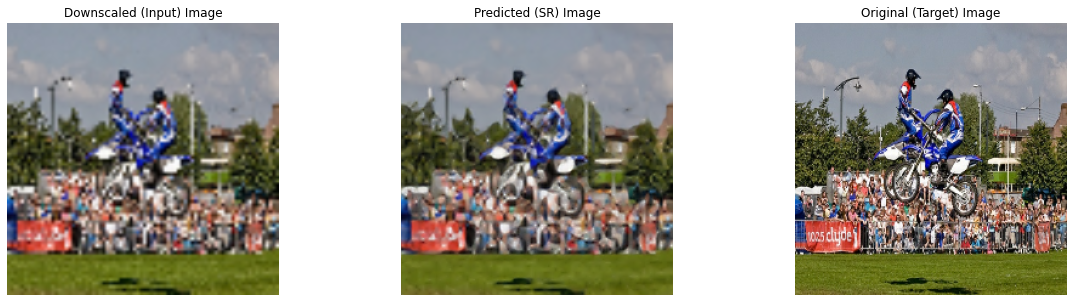

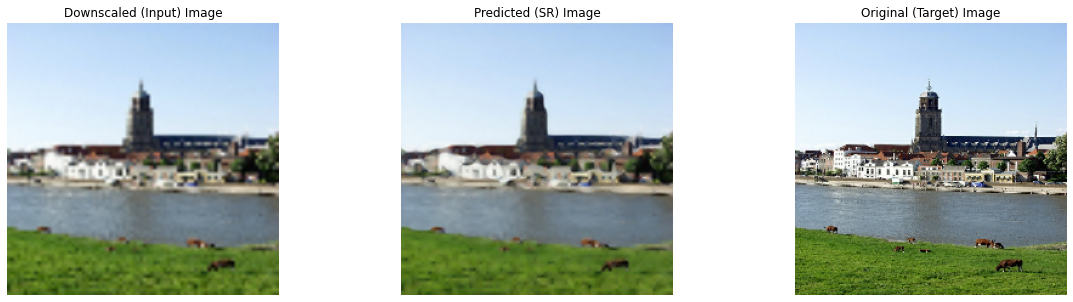

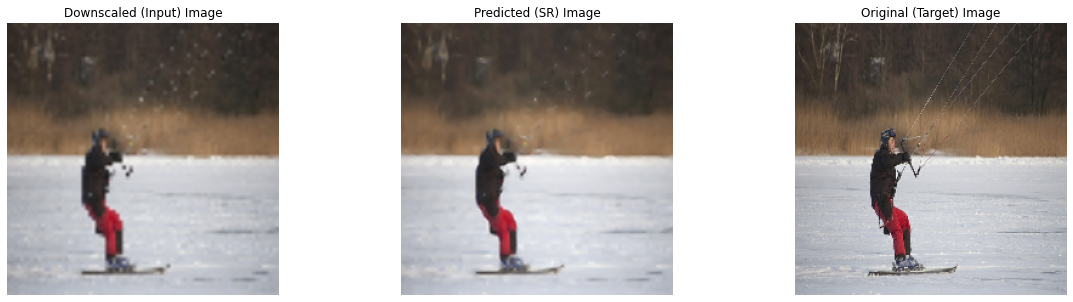

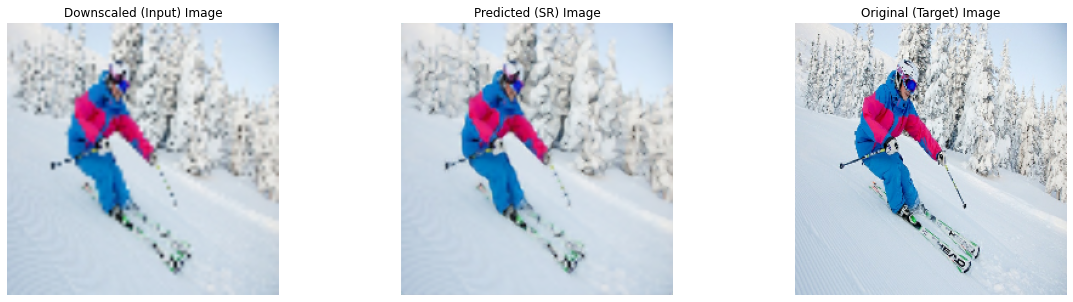

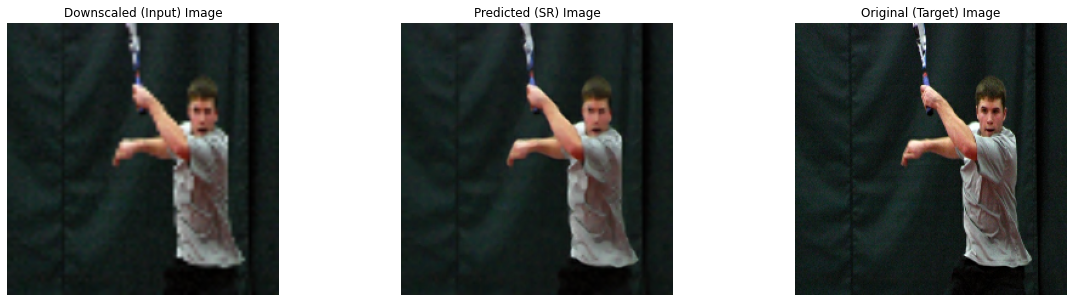

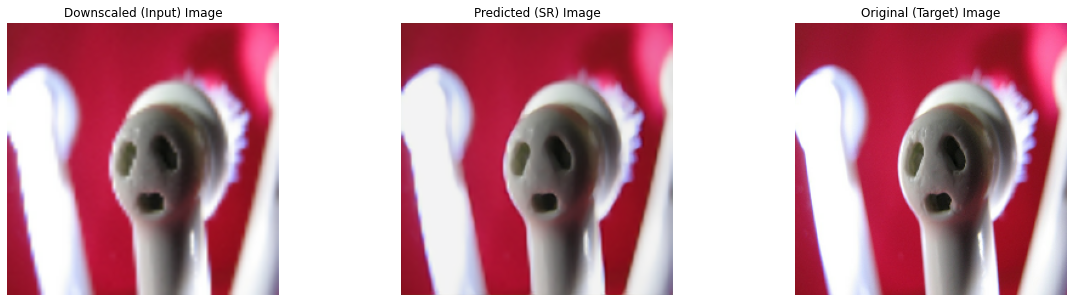

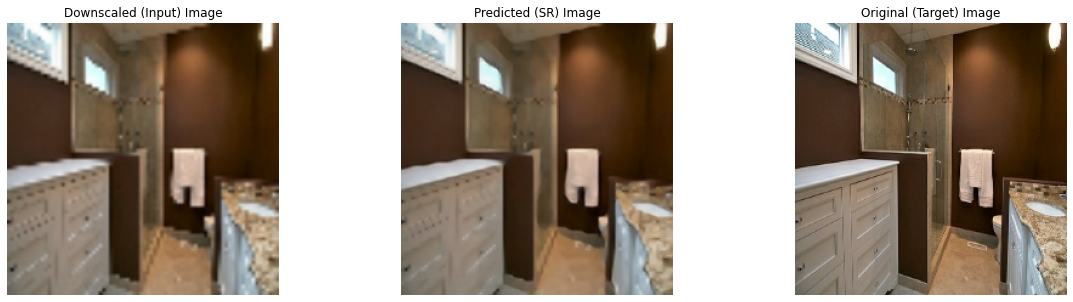

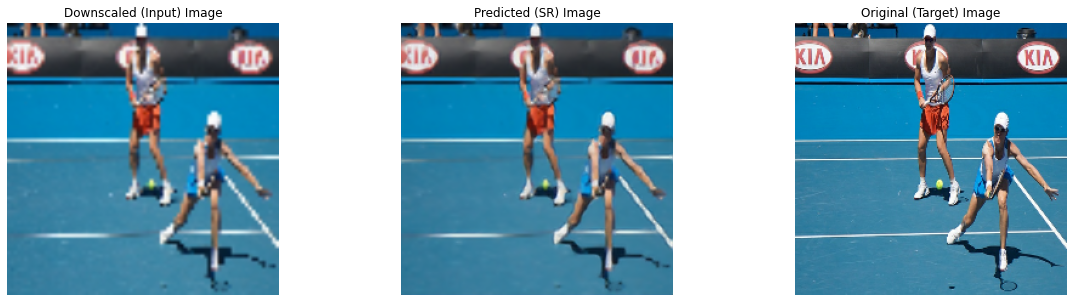

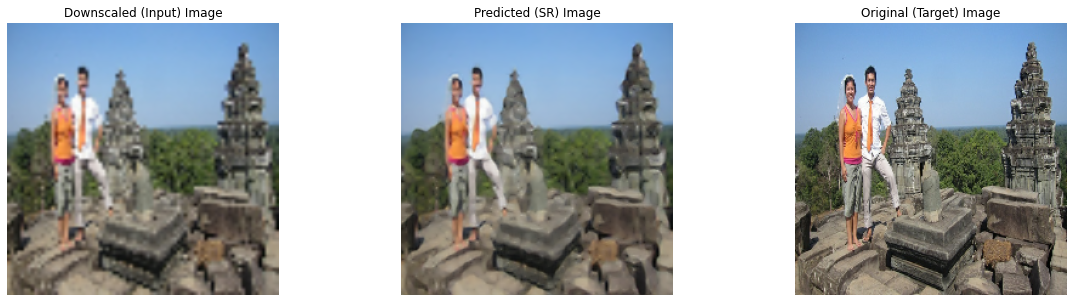

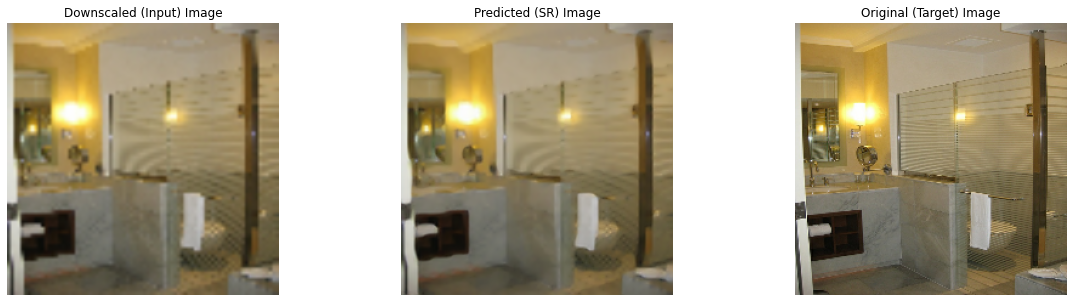

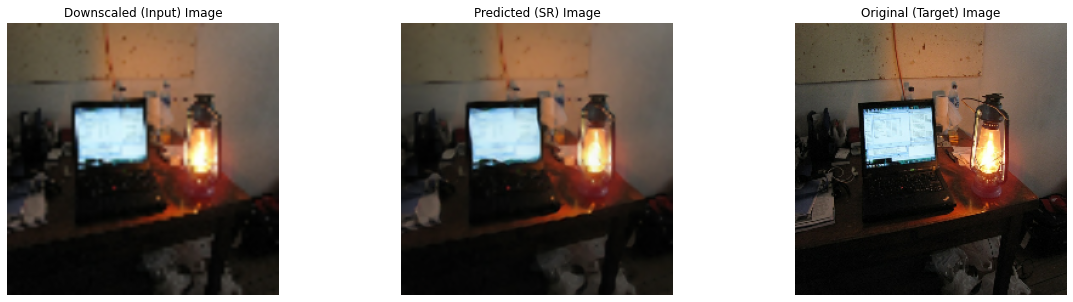

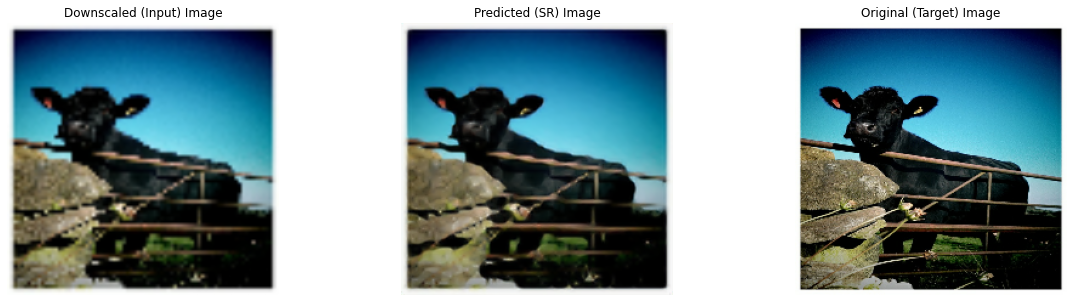

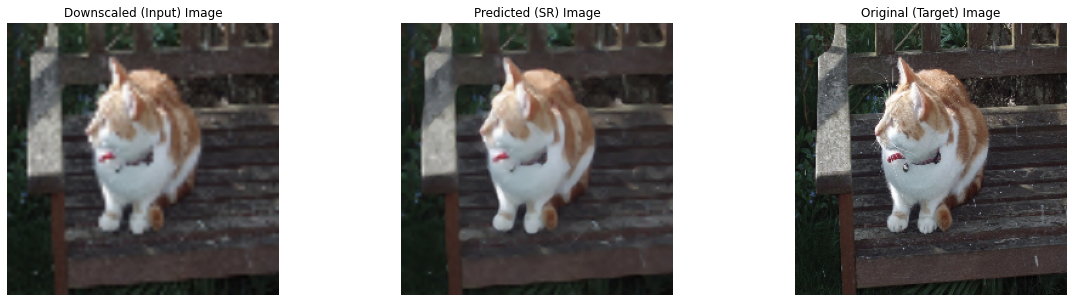

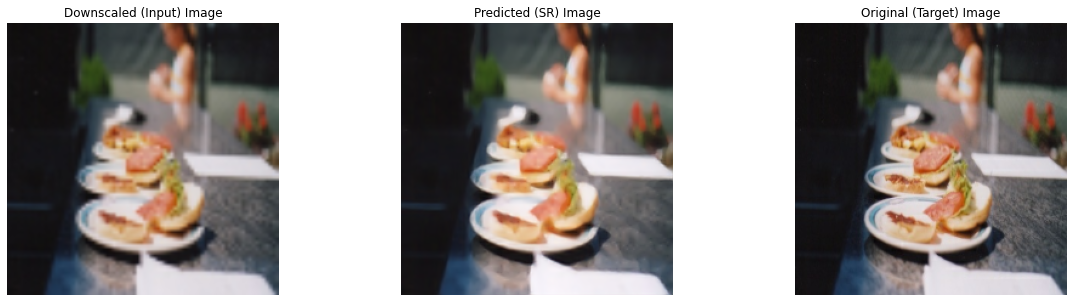

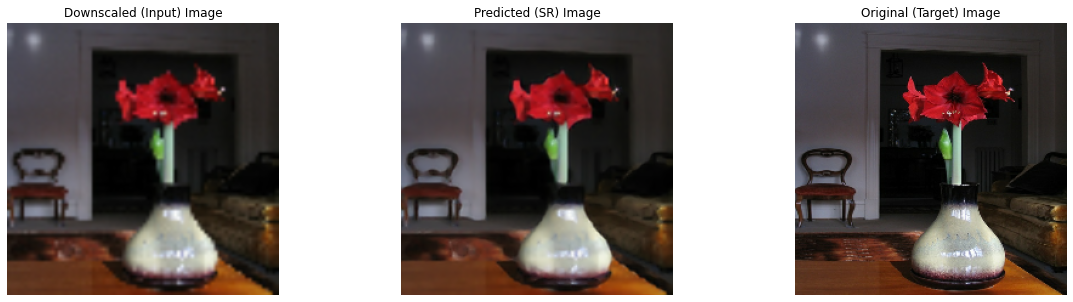

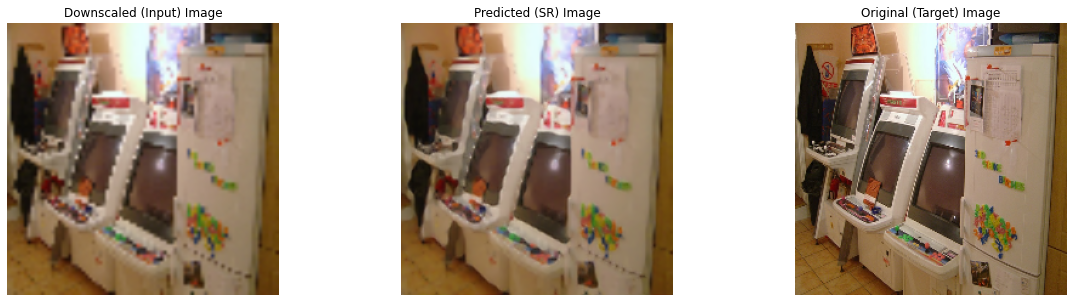

In [11]:
plt.rcParams["figure.figsize"] = (20, 5)

for i, p, t in zip(inputs, preds, targets):
    
    plt.subplot(1, 3, 1)
    plt.imshow(i)
    plt.title("Downscaled (Input) Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(p / tf.math.reduce_max(p))
    plt.title("Predicted (SR) Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(t)
    plt.title("Original (Target) Image")
    plt.axis("off")
    plt.show()